In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import os, logging, glob
from _dataset import dataset
from _logging import set_logging
from _utility import get_perc, get_dictionaries_from_list
from _pckle import save_pickle_object, load_pickle_object

set_logging(logging)
filename = "cats_dogs_model"
model = load_pickle_object(filename)
filename = "cats_dogs_X_test"
X_test = load_pickle_object(filename)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_folder = "cats_dogs_small"

2023-01-24 23:08:02,195 | INFO : Loading pickle file from: pickle\cats_dogs_model
2023-01-24 23:08:04,007 | INFO : Loading pickle file from: pickle\cats_dogs_X_test


In [52]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 1

In [53]:
classes = ["cat", "dog"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)
test_data = dataset(X_test, dict_classes, IMAGE_SIZE, logging)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

In [54]:
model.eval()
df_check_model_data = pd.DataFrame(columns = ["image_path", "prediction", "gt_label", "pred_label"])
with torch.no_grad():
    for i, (image, label_) in enumerate(test_loader):
        gt_label = label_[0].item()
        image = image.to(device)
        image_path = X_test[i]
        preds = model(image)
        prediction_ = torch.sigmoid(preds)[:, 1]
        prediction = prediction_[0].item()
        pred_label = dict_classes["cat"] if prediction < 0.5 else dict_classes["dog"]
        row = [image_path, prediction, gt_label, pred_label]
        df_check_model_data.loc[len(df_check_model_data.index)] = row


In [55]:
df_check_model_data.head(20)


,image_path,prediction,gt_label,pred_label
0,cats_dogs_small\data\test\dog\dog.7490.jpg,0.549426,1,1
1,cats_dogs_small\data\test\dog\dog.6764.jpg,0.825912,1,1
2,cats_dogs_small\data\test\cat\cat.1540.jpg,0.574422,0,1
3,cats_dogs_small\data\test\cat\cat.7580.jpg,0.445077,0,0
4,cats_dogs_small\data\test\cat\cat.7956.jpg,0.496447,0,0
5,cats_dogs_small\data\test\cat\cat.11028.jpg,0.628437,0,1
6,cats_dogs_small\data\test\dog\dog.7735.jpg,0.590606,1,1
7,cats_dogs_small\data\test\dog\dog.4195.jpg,0.526877,1,1
8,cats_dogs_small\data\test\cat\cat.6621.jpg,0.549333,0,1
9,cats_dogs_small\data\test\dog\dog.11883.jpg,0.561955,1,1


In [56]:
df_check_model_data.tail(20)

,image_path,prediction,gt_label,pred_label
104,cats_dogs_small\data\test\cat\cat.2334.jpg,0.355638,0,0
105,cats_dogs_small\data\test\cat\cat.11483.jpg,0.330799,0,0
106,cats_dogs_small\data\test\dog\dog.203.jpg,0.467929,1,0
107,cats_dogs_small\data\test\dog\dog.11998.jpg,0.634226,1,1
108,cats_dogs_small\data\test\dog\dog.8043.jpg,0.675874,1,1
109,cats_dogs_small\data\test\cat\cat.9768.jpg,0.445266,0,0
110,cats_dogs_small\data\test\cat\cat.6725.jpg,0.594961,0,1
111,cats_dogs_small\data\test\dog\dog.3838.jpg,0.590195,1,1
112,cats_dogs_small\data\test\dog\dog.3574.jpg,0.613051,1,1
113,cats_dogs_small\data\test\dog\dog.7644.jpg,0.587728,1,1


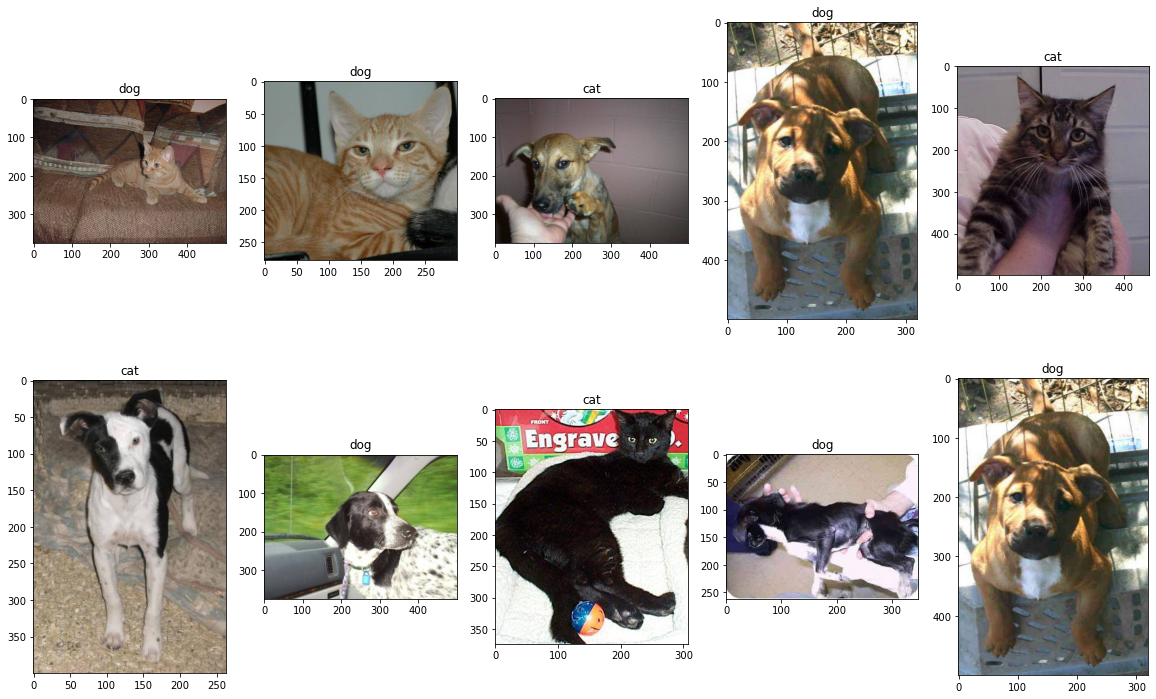

In [57]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        break    
    image_path = random.choice(df_check_model_data['image_path'].values)
    
    label = df_check_model_data.loc[df_check_model_data['image_path'] == image_path, 'pred_label'].values[0]
        
    img = Image.open(image_path)
    
    ax.set_title(dict_classes_rev[label])
    ax.imshow(img)


In [58]:
criterion = nn.CrossEntropyLoss()
test_accuracy = 0
test_loss = 0
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)
    
    test_output = model(data)
    loss = criterion(test_output,label)
    
    
    acc = ((test_output.argmax(dim=1) == label).float().mean())
    test_accuracy += acc/ len(test_loader)
    test_loss += loss/ len(test_loader)
    
print(f'test_accuracy : {test_accuracy}, test_loss : {test_loss}')

test_accuracy : 0.6854833364486694, test_loss : 0.569648265838623


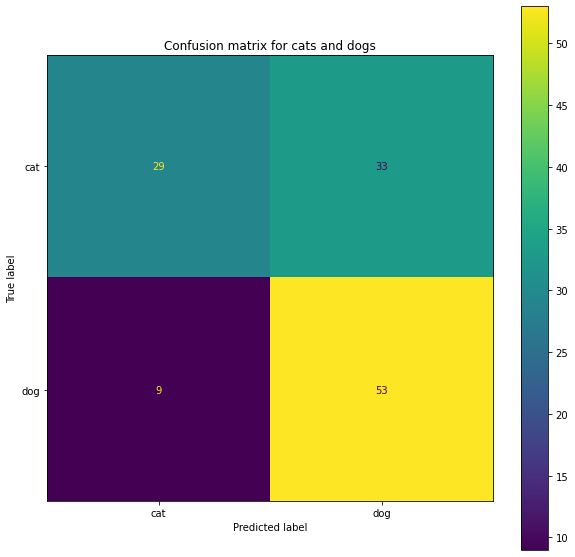

In [62]:
gt_labels = df_check_model_data["gt_label"]
pred_labels = df_check_model_data["pred_label"]
cm = confusion_matrix(y_true=gt_labels, y_pred=pred_labels)
#
# Print the confusion matrix using Matplotlib
#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
title = "Confusion matrix for cats and dogs"
plt.title(title)
plt.show()


In [63]:
cr = classification_report(gt_labels, pred_labels, target_names=classes)
print(cr)

              precision    recall  f1-score   support

         cat       0.76      0.47      0.58        62
         dog       0.62      0.85      0.72        62

    accuracy                           0.66       124
   macro avg       0.69      0.66      0.65       124
weighted avg       0.69      0.66      0.65       124



In [64]:
print(f"Accuracy score = {accuracy_score(y_true=gt_labels, y_pred=pred_labels)}")
print(f"F1 score = {f1_score(y_true=gt_labels, y_pred=pred_labels)}")

Accuracy score = 0.6612903225806451
F1 score = 0.7162162162162162


We can see that the model is much better at predicting dogs than it is for cats.
